In [1]:
import json
import csv
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import scipy
import random

In [2]:
data_dir = Path('../../data')
cello_dir = data_dir / 'CellO_data/bulk_RNA_seq_training_set'
split_dir = cello_dir / 'pretraining_validation_split'

In [3]:
# transposing, so we have columns as features and rows as sample vectors
full_Y_df = pd.read_csv(data_dir / 'mat4.csv').transpose()
full_Y_df.shape

(4293, 55904)

### Separate the data based on CellO split

In [4]:
with open(split_dir / 'validation_bulk_experiments.json', 'r') as f:
    validation_egs = json.load(f)

with open(split_dir / 'pre_training_bulk_experiments.json', 'r') as f:
    train_egs = json.load(f)

In [5]:
train_Y_df = full_Y_df[full_Y_df.index.isin(train_egs)]
train_Y_df.shape

(3609, 55904)

In [6]:
test_Y_df = full_Y_df[full_Y_df.index.isin(validation_egs)]
test_Y_df.shape

(684, 55904)

In [7]:
Z_df = pd.read_csv(data_dir / 'plierResult-cello_train/Z.csv')
Z_mat = Z_df.values
Z_df.shape

(5900, 512)

#### Not all genes from original data(Y) present in Z matrix. Rest of the genes were droped by PLIER as less significant
Let's select only 5900 genes that present in matrix Z. Z is a vertical matrix with columns matching the dimensionality of our embedding vector and number of rows matching the number of genes used

In [8]:
Z_genes = Z_df.index
train_Y_df = train_Y_df[Z_genes]
test_Y_df = test_Y_df[Z_genes]

train_Y_df.shape

(3609, 5900)

#### Loading B matrix built on train data

In [9]:
# transposing, so we have columns as features and rows as sample vectors
B_df = pd.read_csv(data_dir / 'plierResult-cello_train/B.csv').transpose()
B_df.shape

(3609, 512)

Making sure we've trained PLIER on train set

In [10]:
B_samples = B_df.index.values
train_samples = train_Y_df.index.values
assert set(B_samples) == set(train_samples)
assert sum(B_samples != train_samples) == 0

In [11]:
# store samples associated with target embeddings
test_y_vectors = test_Y_df.values

# computing normalization values on train dataset
per_gene_mean = train_Y_df.mean().values
per_gene_std = train_Y_df.std().values

train_y_vectors = (train_Y_df.values - per_gene_mean) / per_gene_std
test_y_vectors = (test_y_vectors - per_gene_mean) / per_gene_std

test_y_vectors.shape

(684, 5900)

## Using regression to find the B that will produce vectors close to test Y

In [12]:
from numpy.linalg import inv

In [13]:
X = Z_mat

# linear least squares
# check this for more details: https://machinelearningmastery.com/solve-linear-regression-using-linear-algebra/
b_test = inv(X.T.dot(X)).dot(X.T).dot(test_y_vectors.T)
b_test.shape

(512, 684)

#### Let's try to compare source Y vales to values reconstructed using Z and reconstructed B

In [14]:
y_test_hat = Z_mat.dot(b_test).transpose()
y_test_hat.shape

(684, 5900)

<AxesSubplot:>

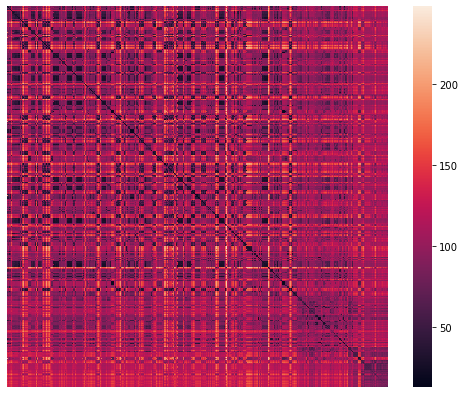

In [16]:
fig, ax = plt.subplots(1, 1, figsize = (9, 7))

y2y_hat_dists = scipy.spatial.distance.cdist(test_y_vectors, y_test_hat)
sns.heatmap(y2y_hat_dists,
    cbar=True,
    annot=False,
    square=True,
    fmt='.2f',
    xticklabels=[],
    yticklabels=[])

### Using Pearson correlation as a distance

In [18]:
def pearson_dists(vectors_a, vectors_b):
    vectors_pairs = zip(vectors_a, vectors_b)
    return [scipy.spatial.distance.correlation(a, b) for a, b in vectors_pairs]

In [23]:
y2y_hat_dists = pearson_dists(test_y_vectors, y_test_hat)
y2y_random_dists = pearson_dists(
    test_y_vectors, 
    random.sample(test_y_vectors.tolist(), len(test_y_vectors))
)

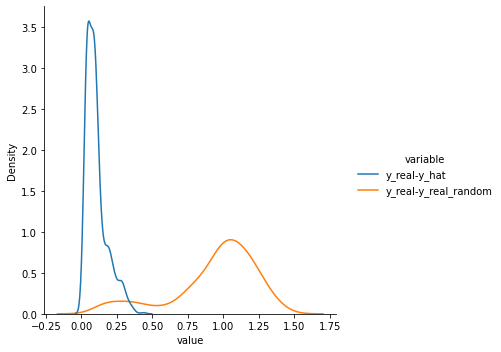

In [24]:
dists_df = pd.DataFrame({
    'y_real-y_hat': y2y_hat_dists,
    'y_real-y_real_random': y2y_random_dists
})

sns.displot(
    data=pd.melt(dists_df, value_vars=dists_df.columns), 
    x='value', hue='variable', kind='kde')

### Existing Z matrix does great job embedding the test data

## Validating embeddings

In [25]:
import sys
sys.path.append('../../onto_lib')

In [26]:
from anndata import AnnData
import scanpy as sc
import general_ontology_tools as got

Unable to import pygraphviz. Visualization is disabled.
Loading ontology from ../../onto_lib\obo\DOID.17-01-30.obo ...
Loading ontology from ../../onto_lib\obo\UBERON.17-01-30.obo ...
Loading ontology from ../../onto_lib\obo\CL.18-11-13.obo ...
Loading ontology from ../../onto_lib\obo\CVCL.17-01-30.obo ...
Loading ontology from ../../onto_lib\obo\EFO.17-01-30.obo ...


In [27]:
with open(data_dir / 'CellO_data/bulk_RNA_seq_training_set/bulk_labels.json', 'r') as f:
    sample2cell_types_ids = json.load(f)

In [28]:
sample2types = {
    sample: list(map(got.get_term_name, types_ids))
    for sample, types_ids in sample2cell_types_ids.items()
}

In [32]:
test_b_vectors = b_test.T
test_samples = test_Y_df.index.values

In [33]:
b_test_df = pd.DataFrame(test_b_vectors)
b_test_df.index = test_samples
b_test_df.columns = B_df.columns
b_test_df.shape

(684, 512)

In [34]:
B_full = pd.concat([B_df, b_test_df])
B_full.shape

(4293, 512)

In [35]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
types_per_b_samples = B_full.index.map(sample2types).values

types_dummies = pd.DataFrame(mlb.fit_transform(types_per_b_samples), columns=mlb.classes_, index=B_full.index)
types_dummies.shape

(4293, 317)

In [42]:
test_mask = B_full.index.isin(test_samples)

In [43]:
ad = AnnData(B_full)

### UMAP

In [44]:
sc.pp.neighbors(ad, use_rep='X', n_neighbors=30)
sc.tl.umap(ad)

In [45]:
def as_category(data):
    return pd.Series(data).astype('category').values

# Add cell type annotations to AnnData object
for ct in types_dummies.columns:
    dummy_mask = types_dummies[ct] == 1
    ct_values = types_dummies[ct].copy()
    ct_values[~dummy_mask] = None
    ct_values[dummy_mask & test_mask] = 'test'
    ct_values[dummy_mask & ~test_mask] = 'train'
    
    ad.obs[ct] = as_category(ct_values)
    
    ad.obs[ct + ' - test'] = as_category(dummy_mask & test_mask)
    ad.obs[ct + ' - train'] = as_category(dummy_mask & ~test_mask)

In [46]:
top_train_types = types_dummies[test_mask].sum().sort_values(ascending=False)[10:25]
# top_train_types

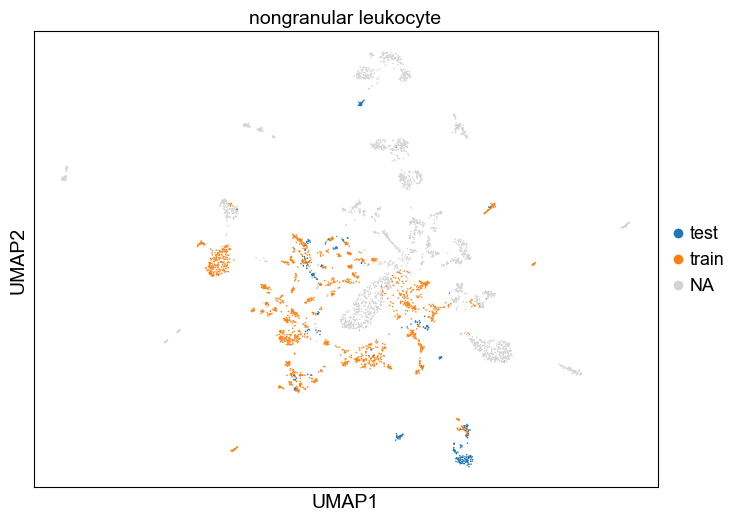

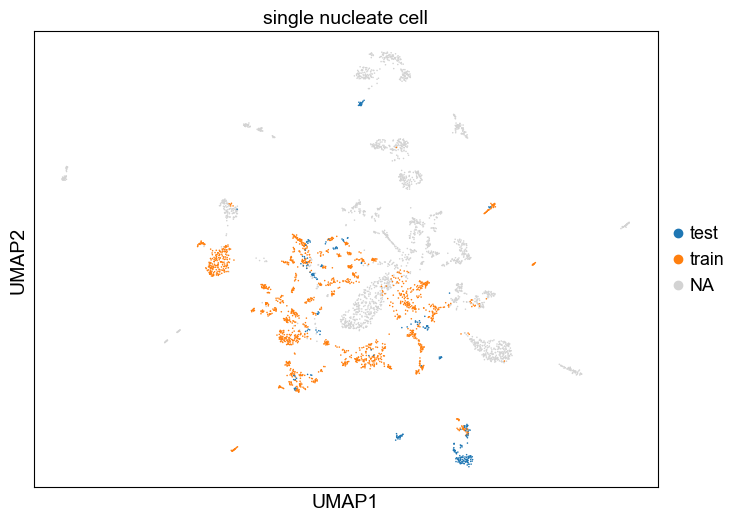

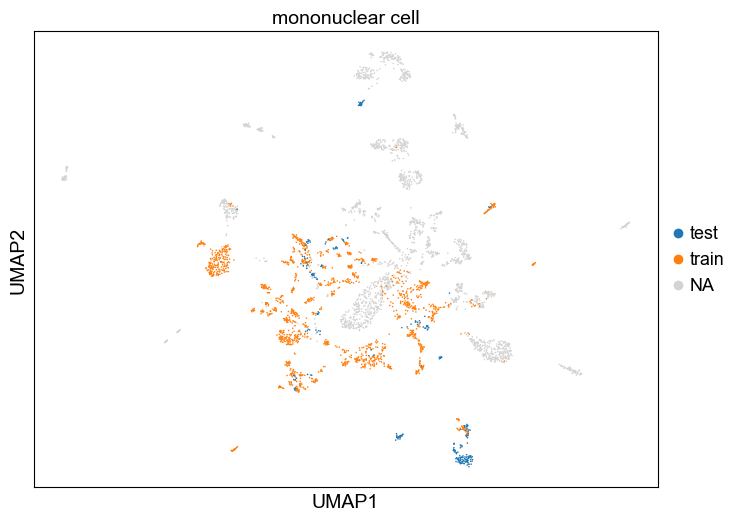

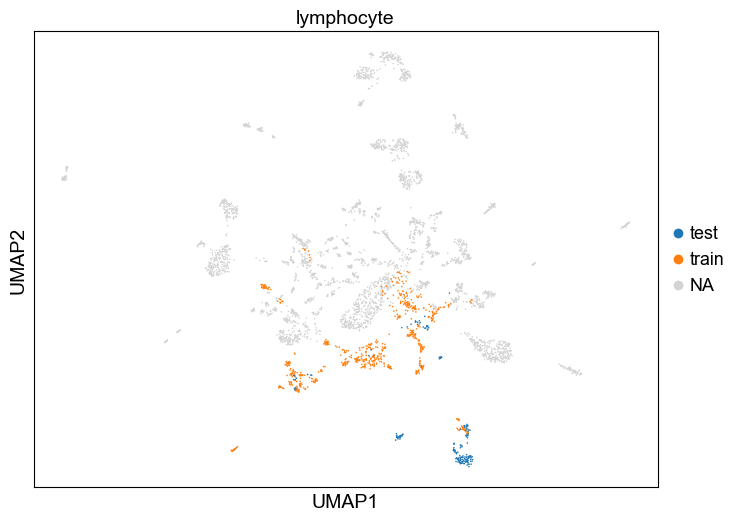

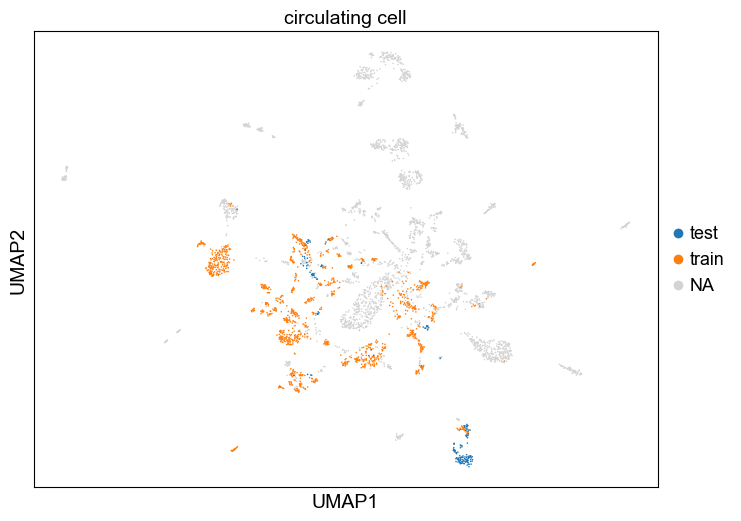

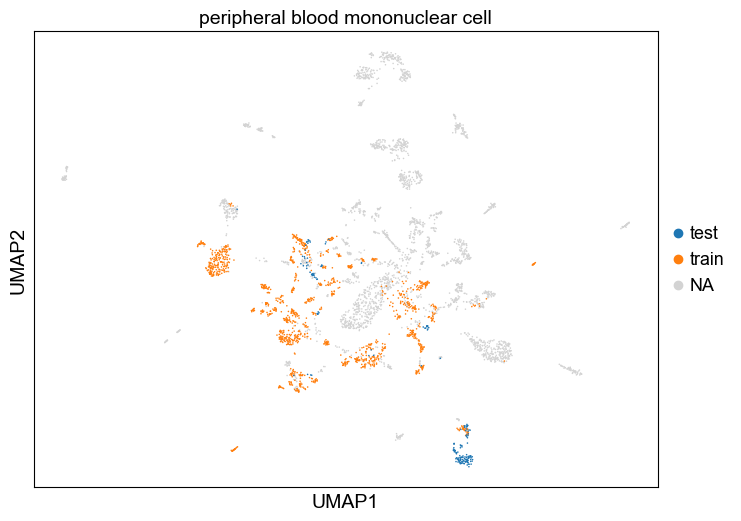

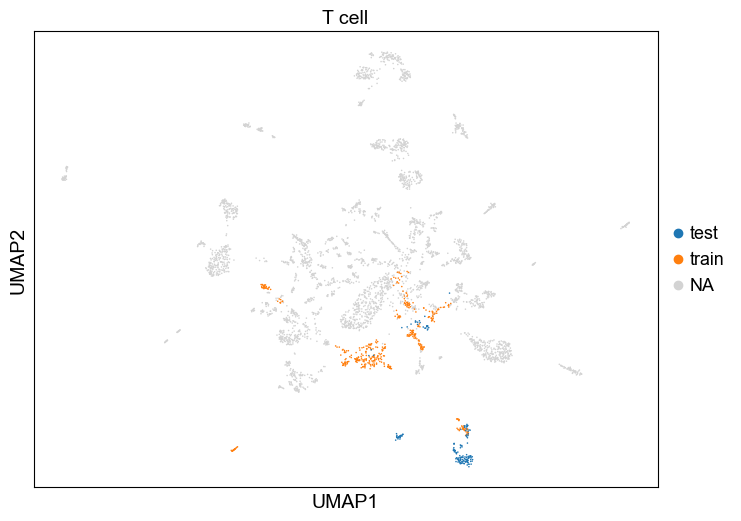

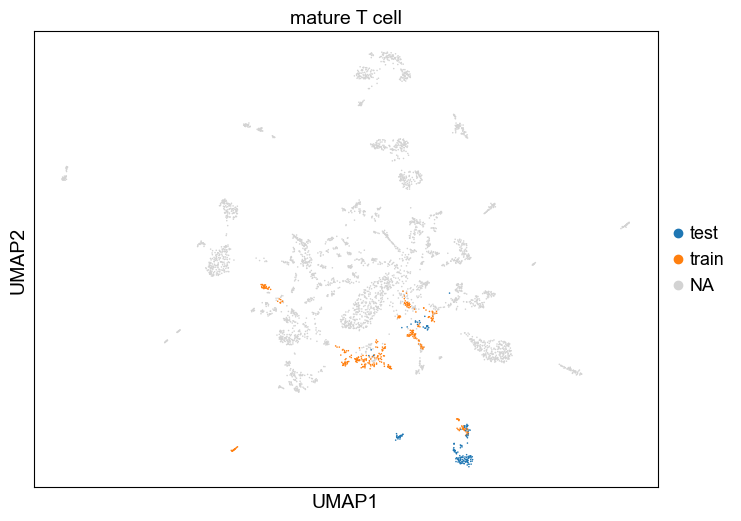

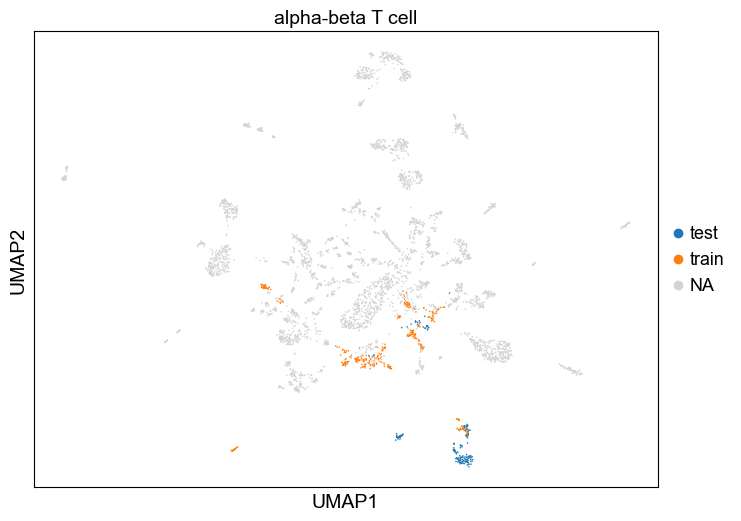

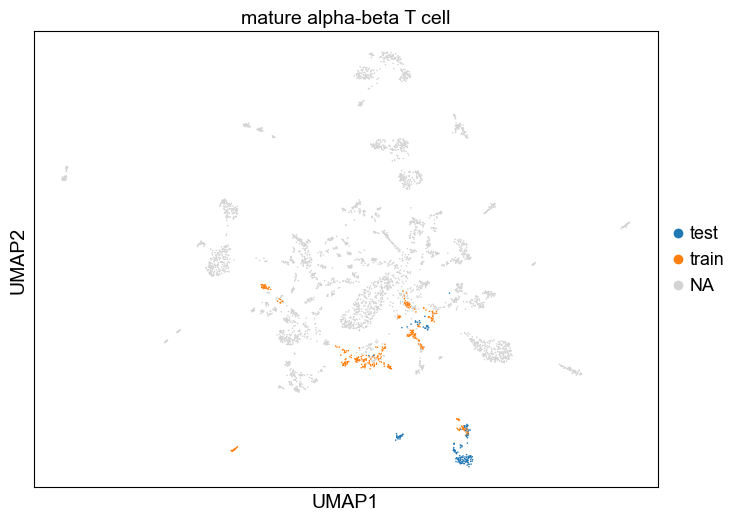

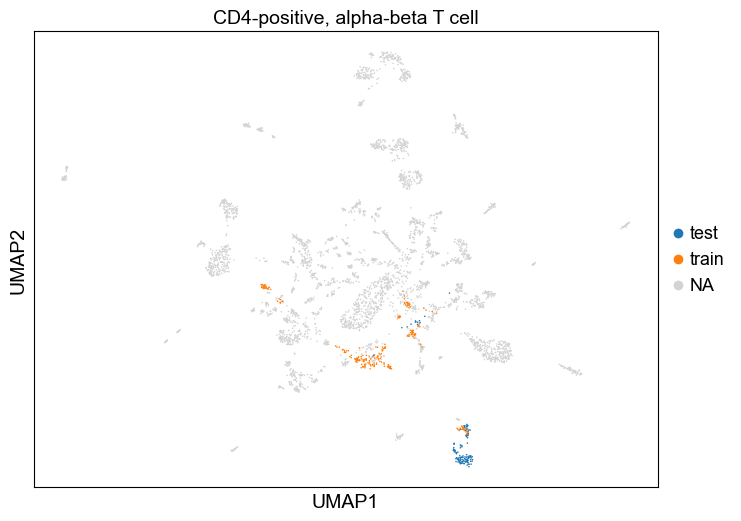

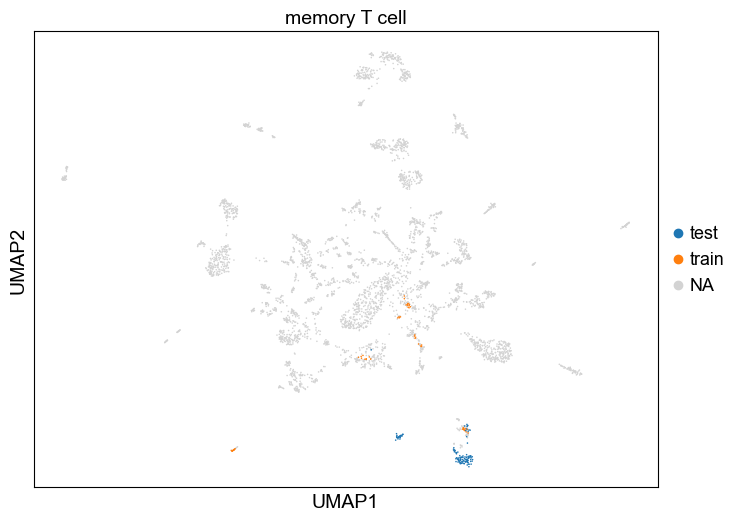

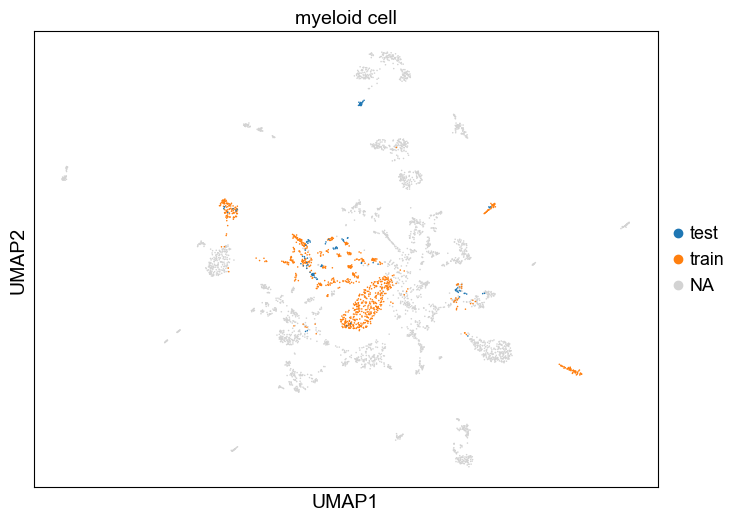

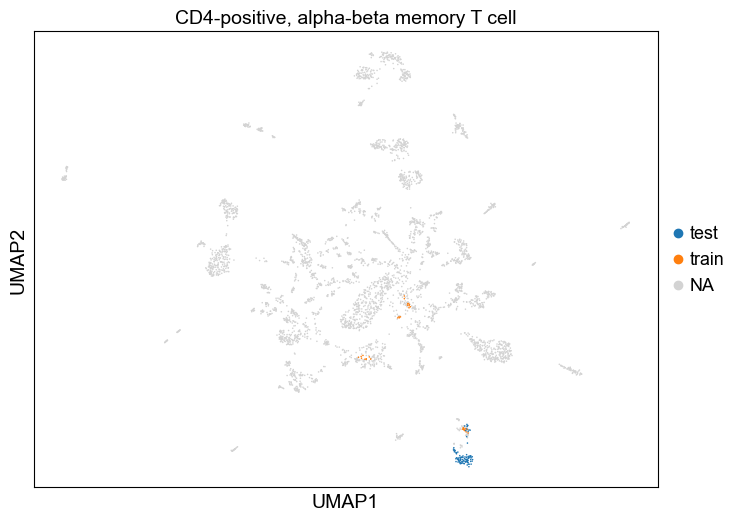

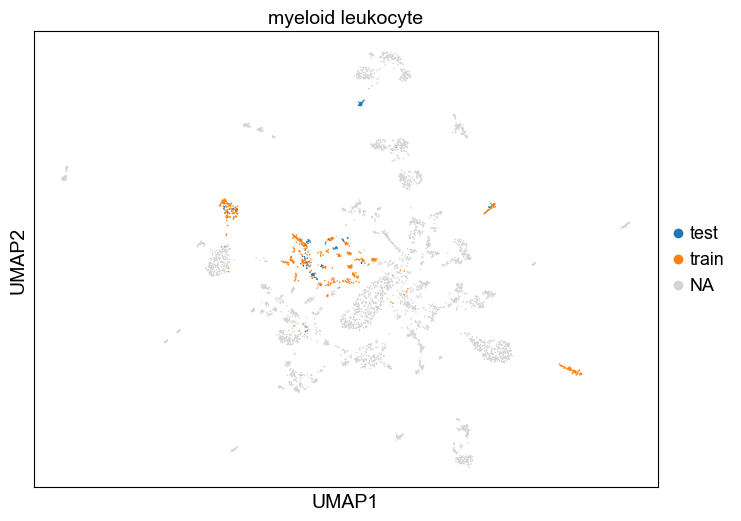

In [47]:
sc.set_figure_params(dpi=100)
plt.rcParams['figure.figsize'] = (8, 6)

for ctype in top_train_types.index:
    sc.pl.umap(ad, color=ctype, size=5, groups=['test', 'train'])
#     sc.pl.umap(ad, color=[ctype + ' - train', ctype + ' - test'], groups=[1])

## Classification

### Compute disstance between the test sample embedding and all train examples

In [48]:
from sklearn.metrics import precision_score, recall_score

In [49]:
def get_pearson_dists(vectors_a, vectors_b):
    vectors_pairs = zip(vectors_a, vectors_b)
    return [scipy.spatial.distance.correlation(a, b) for a, b in vectors_pairs]

In [50]:
def get_pearson_dists_mat(vectors_a, vectors_b):
    return np.array([
        # repeat the A vector for each B vector
        get_pearson_dists(np.array(vector_a[np.newaxis, :]).repeat(len(vectors_b), axis=0), vectors_b)
        for vector_a in vectors_a
    ])

In [71]:
def fscore(p, r):
    denom = p + r or 1

    return (p * r) / denom

def get_scores(cell_type_y, cell_type_y_hat):
    precision_scores = []
    recall_scores = []
    f_scores = []

    for ctype in cell_type_y.columns:
        y_pred = cell_type_y_hat[ctype].values
        y_true = cell_type_y[ctype].values

        # calculate precision only if we have predictions for this cell type
        if y_pred.sum() > 0:
            precision_scores.append(precision_score(y_true, y_pred))

        # calculate recall only if we have true activations for this cell type
        if y_true.sum() > 0:
            recall_scores.append(recall_score(y_true, y_pred))
        
        # calculate f1 score only if we have precision and recall
        if y_pred.sum() > 0 and y_true.sum() > 0:
            f_scores.append(fscore(precision_scores[-1], recall_scores[-1]))
    
    p = np.mean(precision_scores)
    r = np.mean(recall_scores)
    f = np.mean(f_scores)
    f_micro = fscore(p, r)
    
    print(f'precision: {p:.4f}, recall: {r:.4f}, f1: {f:.4f}, f1 micro avg: {f_micro:.4f}')

    return {
        'precision_scores': precision_scores, 
        'recall_scores': recall_scores, 
        'f_scores': f_scores, 
        'precision': p, 
        'recall': r, 
        'f1': f, 
        'f1_micro_avg': f_micro
    }

def classify_by_dists(test_2_train_dists):
    # distances is a n_test X n_train matrix
    # with columns for test items and rows for train items
    dists_df = pd.DataFrame(test_2_train_dists)
    dists_df.columns = test_samples
    dists_df.index = train_samples
    
    # map each test item to it's closest train one using dists matrix
    test_sample2closest_train = {
        # get the column for current test sample and find the index of raw the closest value
        sample_id: dists_df[sample_id].sort_values().index[0]
        for sample_id in test_samples
    }
    
    # predict each cell type just by looking at closest item for each test sample
    cell_types_y_predicted = pd.DataFrame([
        types_dummies.loc[test_sample2closest_train[test_id]] 
        for test_id in test_samples
    ])

    # get true values for each cell type for each test sample
    cell_types_y_true = types_dummies[test_mask]
    assert (cell_types_y_true.index != test_samples).sum() == 0
    
    # calculate precision, recall, F1 scores
    return get_scores(cell_types_y_true, cell_types_y_predicted)

In [72]:
all_results = {}

In [73]:
B_mat = B_df.values
B_mat.shape

(3609, 512)

In [74]:
test_b_to_train_samples_dists = scipy.spatial.distance.cdist(B_mat, b_test.T)

In [75]:
all_results['euclidean-dist-on-embeddings'] = classify_by_dists(test_b_to_train_samples_dists)

precision: 0.6404, recall: 0.5552, f1: 0.3275, f1 micro avg: 0.2974


In [76]:
pearson_dists = get_pearson_dists_mat(B_mat, b_test.T)
pearson_dists.shape

(3609, 684)

In [77]:
all_results['pearson-dist-on-embeddings'] = classify_by_dists(pearson_dists)

precision: 0.6644, recall: 0.5657, f1: 0.3511, f1 micro avg: 0.3056


### Classification using raw data

In [78]:
test_y_to_train_samples_dists = scipy.spatial.distance.cdist(train_y_vectors, test_y_vectors)

In [79]:
all_results['euclidean-dist-on-norm-Y-vectors'] = classify_by_dists(test_y_to_train_samples_dists)

precision: 0.6554, recall: 0.4866, f1: 0.3162, f1 micro avg: 0.2793


In [80]:
pearson_dists_raw = get_pearson_dists_mat(train_y_vectors, test_y_vectors)
pearson_dists_raw.shape

(3609, 684)

In [81]:
all_results['pearson-dist-on-norm-Y-vectors'] = classify_by_dists(pearson_dists_raw)

precision: 0.6556, recall: 0.5396, f1: 0.3334, f1 micro avg: 0.2960


In [84]:
results_df = pd.DataFrame(all_results).T
results_df[['precision', 'recall', 'f1', 'f1_micro_avg']]

,precision,recall,f1,f1_micro_avg
euclidean-dist-on-embeddings,0.640442,0.555224,0.327488,0.297398
pearson-dist-on-embeddings,0.664411,0.565737,0.35105,0.305558
euclidean-dist-on-norm-Y-vectors,0.655385,0.486641,0.31622,0.279273
pearson-dist-on-norm-Y-vectors,0.655642,0.539561,0.333362,0.295982


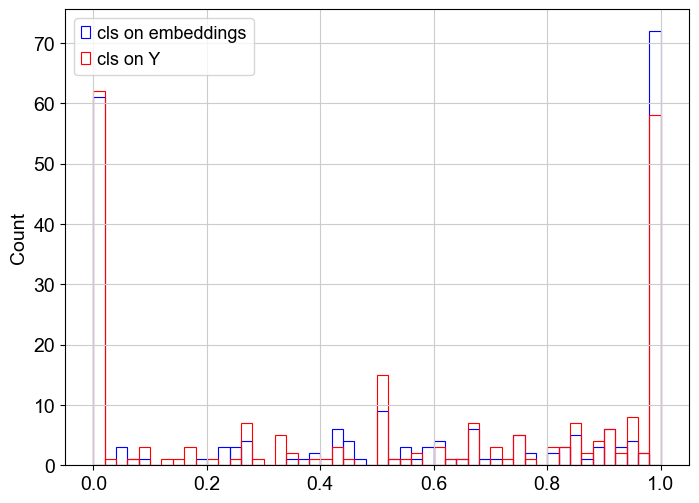

In [108]:
sns.histplot(results_df.loc['pearson-dist-on-embeddings', 'recall_scores'], color='blue', label='cls on embeddings', 
             bins=50, fill=False)
sns.histplot(results_df.loc['pearson-dist-on-norm-Y-vectors', 'recall_scores'], color='red', label='cls on Y', 
             bins=50, fill=False)

plt.legend()
plt.show()